/Users/justin/Desktop/ML-Lab/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Product 1 description:
Lapel collar bomber jacket with long sleeves and buttoned cuffs. Shoulder tab detail. Front welt pockets. Elastic hem. Front zip closure.

Product images:


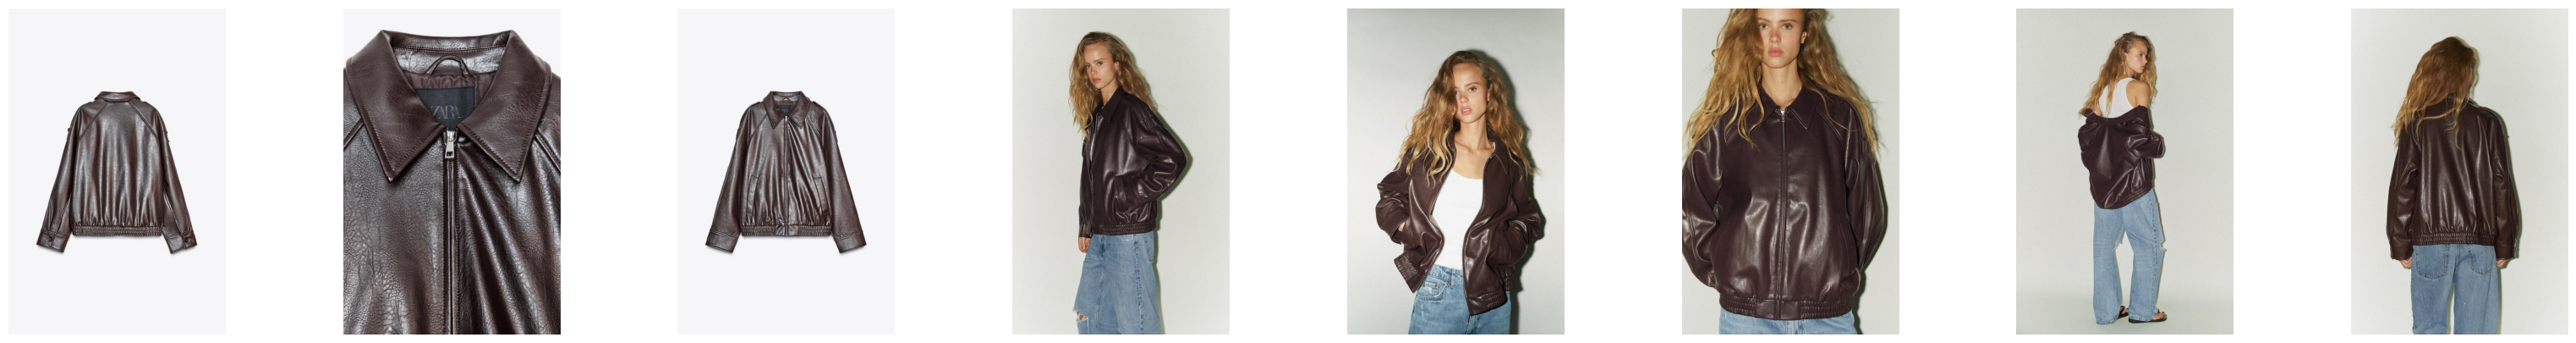

In [1]:
import open_clip

import torch
from PIL import Image

import os
from pathlib import Path
import matplotlib.pyplot as plt

model, _, preprocess_val = open_clip.create_model_and_transforms('hf-hub:Marqo/marqo-fashionSigLIP')
tokenizer = open_clip.get_tokenizer('hf-hub:Marqo/marqo-fashionSigLIP')

def load_product_data(base_path="./products"):
    products = []
    
    # Iterate through product folders
    for product_dir in sorted(os.listdir(base_path)):
        product_path = Path(base_path) / product_dir
        
        if not product_path.is_dir():
            continue
            
        # Load text
        text_files = list(product_path.glob("text/*.txt"))
        text_content = ""
        if text_files:
            with open(text_files[0], 'r') as f:
                text_content = f.read().strip()
                
        # Load images
        images = []
        for img_path in product_path.glob("images/*.jpg"):
            images.append(Image.open(img_path))
            
        products.append({
            "id": product_dir,
            "text": text_content,
            "images": images
        })
        
    return products

# Load first product
products = load_product_data()
if products:
    product = products[0]

    print(f"Product {product['id']} description:")
    print(product['text'])
    print("\nProduct images:")
    
    # Display all images
    n_images = len(product['images'])
    if n_images > 0:
        fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
        if n_images == 1:
            axes = [axes]
        for ax, img in zip(axes, product['images']):
            ax.imshow(img)
            ax.axis('off')
        plt.show()


In [2]:

# Get image embeddings for all product images
image_embeddings = []
for img in product['images']:
    preprocessed_img = preprocess_val(img).unsqueeze(0)
    img_embedding = model.encode_image(preprocessed_img, normalize=True)
    image_embeddings.append(img_embedding)

# Stack all image embeddings
image_features = torch.cat(image_embeddings, dim=0)

# Get text embedding
text = tokenizer([product['text']])
text_features = model.encode_text(text, normalize=True)

# Compute cosine similarity between text and each image
similarities = torch.nn.functional.cosine_similarity(text_features.unsqueeze(1), image_features)

print("Cosine similarities between text and images:")
for i, sim in enumerate(similarities[0]):
    print(f"Image {i+1}: {sim:.3f}")


Cosine similarities between text and images:
Image 1: -0.769
Image 2: 0.460
Image 3: -0.815
Image 4: 0.337
Image 5: -0.088
Image 6: 0.862
Image 7: 0.732
Image 8: -0.268
Image 9: 0.771
Image 10: 0.750
Image 11: 0.080
Image 12: 0.710
Image 13: 0.947
Image 14: -0.940
Image 15: 0.849
Image 16: -0.091
Image 17: 0.032
Image 18: -0.799
Image 19: -0.539
Image 20: 0.612
Image 21: -0.700
Image 22: 0.963
Image 23: 0.494
Image 24: 0.954
Image 25: 0.205
Image 26: -0.918
Image 27: -0.698
Image 28: -0.879
Image 29: -0.835
Image 30: -0.683
Image 31: 0.580
Image 32: -0.921
Image 33: -0.578
Image 34: 0.832
Image 35: 0.972
Image 36: -0.765
Image 37: 0.839
Image 38: -0.158
Image 39: 0.872
Image 40: 0.330
Image 41: 0.547
Image 42: -0.922
Image 43: 0.580
Image 44: 0.951
Image 45: -0.702
Image 46: 0.314
Image 47: -0.426
Image 48: -0.905
Image 49: 0.701
Image 50: -0.977
Image 51: 0.498
Image 52: 0.443
Image 53: 0.921
Image 54: 0.066
Image 55: 0.893
Image 56: 0.814
Image 57: -0.952
Image 58: -0.971
Image 59: 0

In [ ]:
from product_representation import MultiModalProductEncoder

# Initialize the multimodal encoder
model_config = {
    'embedding_dim': 768,
    'image_fusion_hidden_dim': 512,
    'image_fusion_heads': 8,
    'image_fusion_layers': 2, 
    'cross_modal_hidden_dim': 1024,
    'dropout': 0.1
}

multimodal_encoder = MultiModalProductEncoder(**model_config)

# Prepare inputs for the encoder
# Ensure image features have shape [batch_size, num_images, embedding_dim]
image_features = image_features.reshape(1, len(product['images']), -1)

# Ensure text features have shape [batch_size, embedding_dim] 
text_features = text_features.squeeze(0).unsqueeze(0)

# Create mask for valid images (all True since we have no padding)
image_mask = torch.ones(1, len(product['images']), dtype=torch.bool)

# Get fused product embedding
product_embedding = multimodal_encoder(image_features, text_features, image_mask)

print("\nFused product embedding shape:", product_embedding.shape)
print("Fused embedding L2 norm:", torch.norm(product_embedding, dim=1))



/Users/justin/Desktop/ML-Lab/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Fused product embedding shape: torch.Size([1, 768])
Fused embedding L2 norm: tensor([27.7118], grad_fn=<LinalgVectorNormBackward0>)
tensor([[ 6.1540e-01,  1.0014e+00,  5.4769e-01,  9.2858e-02,  9.0787e-01,
          5.4385e-01,  6.7102e-01,  7.8121e-01,  1.8806e+00, -1.2064e+00,
          2.0963e-01,  9.7810e-01,  1.4637e+00, -4.1207e-01, -4.1236e-01,
         -1.2775e+00, -2.4736e-01, -2.9654e-01,  1.4445e+00, -6.4652e-01,
          4.6166e-01, -5.1264e-01,  2.3750e+00,  1.4860e+00, -1.4662e+00,
         -5.0055e-01,  8.0877e-01, -1.7216e+00, -7.5396e-01, -2.2457e+00,
         -1.3504e-01,  1.4907e+00,  1.2915e+00, -2.3151e-01, -1.0116e+00,
         -7.6654e-01,  1.1404e+00, -2.6913e+00,  3.6083e-01, -8.4928e-01,
          1.4251e-01, -5.7413e-01,  2.2779e+00, -5.1867e-01,  1.9823e-01,
          5.1480e-01, -2.2014e-01,  6.4737e-01,  1.3089e+00,  5.4397e-01,
          1.1785e+00, -2.0353e+00,  4.1609e-02,  1.6729e+00, -1.3514e+00,
          1.8281e-01, -8.0442e-02, -2.3515e-01, -4.26